In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import pathlib
import glob as glob

import hydra
from omegaconf import OmegaConf
import jax.numpy as jnp
import jax.random as jr
import matplotlib.pyplot as plt

from cohlib.observations import sample_obs
from cohlib.utils import add0, jax_boilerplate, pickle_save, pickle_open

import cohlib.confs.utils as conf
from cohlib.confs.latent import create_lrccn_basic_rank1
from cohlib.confs.config import get_sim_config

In [3]:
# Get plots for previously saved data with large oscillations / high rate

In [4]:
import jax.numpy as jnp
from typing import Any

def hermitize_from_upper(A: jnp.ndarray) -> jnp.ndarray:
    """
    Construct a Hermitian matrix by copying the conjugate-transpose of the
    upper-triangular part of `A` (excluding the diagonal) into the strictly
    lower-triangular part.

    Parameters
    ----------
    A : jnp.ndarray
        Square complex (or real) array of shape (N, N).

    Returns
    -------
    H : jnp.ndarray
        Hermitian array with H == H.conj().T.

    Raises
    ------
    ValueError
        If `A` is not a square matrix.

    Notes
    -----
    * Works with any JAX dtype that implements `.conj()`.
    * Does **not** modify `A` in-place; a new array is returned.
    * You can `jax.jit`-compile the function externally if desired.
    """
    if A.ndim != 2 or A.shape[0] != A.shape[1]:
        raise ValueError("Input must be a square matrix.")

    # Strict upper-triangle (k=1 excludes the diagonal)
    strict_upper = jnp.triu(A, k=1)

    # Diagonal preserved as-is
    diag = jnp.diag(jnp.diag(A))

    # Assemble Hermitian matrix:   H = diag + U + Uᴴ
    H = diag + strict_upper + strict_upper.conj().T
    return H


# --- Example --------------------------------------------------------------
if __name__ == "__main__":
    import jax

    A = jnp.array([[1+0j, 2+3j, 4-1j],
                   [7+5j, 5+0j, 6+2j],
                   [8-4j, 9+1j, 3+0j]])

    H = hermitize_from_upper(A)
    print("Hermitian matrix:\n", H)
    print("Is Hermitian?", jnp.allclose(H, H.conj().T))

    # Optional: JIT-compile for speed on repeated calls
    hermitize_jit = jax.jit(hermitize_from_upper)


Hermitian matrix:
 [[1.+0.j 2.+3.j 4.-1.j]
 [2.-3.j 5.+0.j 6.+2.j]
 [4.+1.j 6.-2.j 3.+0.j]]
Is Hermitian? True


In [5]:
gseed_use = 0
seed_use = 0
# temp = "/projectnb/stephenlab/jtauber/cohlib/experiments/data/latent-basic_single_log_rank1/window1000/gseed0/K3/L5/lseed0/obs-pp_log/mu0.8/oseed0/model-simple_inherit_latent_fullrank/inherit-True/m_step-full-rank-standard/empirical-init/newton-10_em-20/res.pkl"
# temp = "/projectnb/stephenlab/jtauber/cohlib/experiments/data/latent-basic_single_log_rank1/scale1000000/window1000/gseed0/K3/L5/lseed0/obs-pp_log/mu0.8/oseed0/model-simple_inherit_latent_fullrank_pinv/inherit-True/m_step-full-rank-standard/empirical-init/newton-10_em-20/res.pkl"
scale_power = int(5e4)
mu = 2.3
temp = f"/projectnb/stephenlab/jtauber/cohlib/experiments/data/latent-basic_single_log_rank1/scale{scale_power}/window1000/gseed0/K5/L25/lseed0/obs-pp_log/mu{mu}/oseed0/model-simple_inherit_latent_fullrank_pinv/inherit-True/m_step-full-rank-standard/empirical-init/newton-10_em-20/res.pkl"
res = pickle_open(temp)
cfg = conf.omega(res['cfg'])

cfg.latent.gamma_seed = gseed_use
cfg.latent.seed = seed_use
cfg.obs.seed = seed_use
nz_model = jnp.array([cfg.latent.target_freq_ind])

In [6]:
res['track'].keys()

dict_keys(['ccn', 'alphas', 'Upss'])

In [93]:
r = 19
alpha = res['track']['alphas'][r].squeeze()
Ups = res['track']['Upss'][r].squeeze()

In [94]:
alpha.shape

(5, 25)

In [95]:
l = 1
temp = Ups[:,:,l]

In [96]:
print(jnp.linalg.eig(temp)[0])
print(jnp.linalg.eigh(temp)[0])

[34231.016 -5.1117229e+01j 14133.636 -7.5525069e+00j
  8192.775 -3.9988998e-01j  5747.2134-2.2620134e+00j
  3935.8235+5.3256867e-03j]
[ 3935.8262  5747.202   8192.768  14133.617  34231.035 ]


(-50000.0, 50000.0)

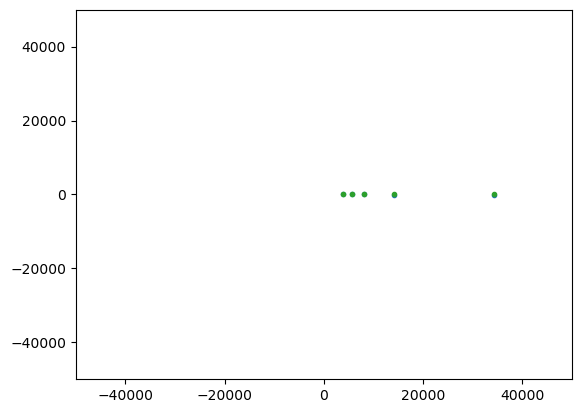

In [97]:
box_lim = 50000
evs = jnp.linalg.eig(temp)[0]
ehvs = jnp.linalg.eigh(temp)[0]
plt.plot(evs.real, evs.imag, '.', color='tab:blue')
plt.plot(ehvs, jnp.zeros_like(ehvs), '.', color='tab:green')
plt.xlim([-box_lim, box_lim])
plt.ylim([-box_lim, box_lim])

In [98]:
evs*jnp.exp(-1j*jnp.angle(evs)[0])

Array([34231.055 +6.6920279e-07j, 14133.631 +1.3553258e+01j,
        8192.767 +1.1834380e+01j,  5747.2104+6.3203015e+00j,
        3935.819 +5.8826904e+00j], dtype=complex64)

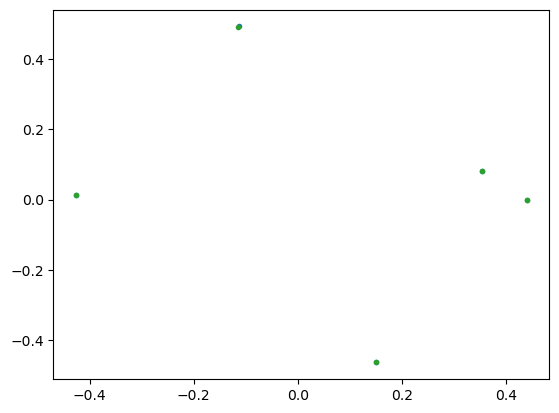

In [99]:
ev_order = 0
box_lim = 50000
evs = jnp.linalg.eig(temp)[1][:,ev_order]
evs = evs*jnp.exp(-1j*jnp.angle(evs)[0])
ehvs = jnp.linalg.eigh(temp)[1][:,-(1+ev_order)]
ehvs = ehvs*jnp.exp(-1j*jnp.angle(ehvs)[0])
plt.plot(evs.real, evs.imag, '.', color='tab:blue')
plt.plot(ehvs.real, ehvs.imag, '.', color='tab:green')
# plt.plot(evs.imag, '.', color='tab:blue')
# plt.plot(ehvs.imag, '.', color='tab:green')
# plt.xlim([-box_lim, box_lim])
# plt.ylim([-box_lim, box_lim])

This tells us that the non-Hermitian $\Upsilon$ is very close to Hermitian, and that reconstructing it as Hermitian by using `eigh` will not generally change our results. 

Let's test this in practice / document to be sure. 

In [15]:
# jind_nz = 0
# lrccn_true = conf.create_lrccn_basic_rank1(cfg.latent)
# eigvals_true = lrccn_true.eigvals[0,:]

# eigvals_model = get_ccn_fullrank_eigvals(res['ccn_est'])[0,:]

# latent_dir = conf.get_latent_dir(cfg.latent)
# latent_load = pickle_open(os.path.join(latent_dir, 'latent_sim.pkl'))
# zs_nz = latent_load['zs_nz']
# freqs = latent_load['freqs']
# nz_true = latent_load['nz']

# gamma_oracle = jnp.einsum('jkl,jil->jkil', zs_nz, zs_nz.conj()).mean(-1)
# eigvals_oracle = jnp.linalg.eigh(gamma_oracle[jind_nz,:,:])[0][::-1]
# # eigval_oracle = get_eigval(gamma_oracle[jind_nz,:,:], eigrank)

# obs_dir = conf.get_obs_dir(cfg.obs, latent_dir)
# obs_load = pickle_open(os.path.join(obs_dir, 'obs_sim.pkl'))
# obs = obs_load['obs']

### OK let's think through what comes after this 
- compare to naive estimator
   - make adjustments if needed
- repeat process for oracle/true
    - may need to threshold eigvals because low rank!
- remake plots with existing data but with pushforward

In [23]:
Ks = [5, 10, 20]
K = 10
mu = 2.3
L = 25
num_seeds = 200
seed_mod = 0
seeds = [x + seed_mod for x in range(num_seeds)]
# sps = [int(1e4), int(5e4)]
scale_power = int(5e4)
plot_dict = get_plot_dict(eigval_all_pushforward_model_true_oracle, cfg, scale_power, K, L, mu, seeds)

In [24]:
sorted_naive = jnp.stack(plot_dict['naive']).sort(0)/K
naive_low = sorted_naive[5,:]
naive_high = sorted_naive[195,:]

sorted_model = jnp.stack(plot_dict['model']).sort(0)/K
model_low = sorted_model[5,:]
model_high = sorted_model[195,:]

sorted_oracle = jnp.stack(plot_dict['oracle']).sort(0)/K
oracle_low = sorted_oracle[5,:]
oracle_high = sorted_oracle[195,:]

In [25]:
import seaborn as sns
sns.set_palette('muted')
current_palette = sns.color_palette()
sns.set_context("notebook")

In [26]:
save_path = '/projectnb/stephenlab/jtauber/cohlib/experiments/poster_figures'

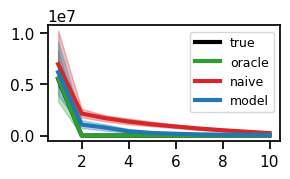

In [27]:
# func = jnp.log
# func = lambda x: jnp.log(x + 1e-1)
# func = lambda x: jnp.log(jnp.abs(x))
func = lambda x: x
# alf = 0.2
# for n in range(nseeds):
#     plt.plot(func(plot_dict['naive'][n]), color='tab:red', alpha=alf)
#     plt.plot(func(plot_dict['model'][n]), color='tab:blue', alpha=alf)
#     plt.plot(func(plot_dict['oracle'][n]), color='tab:green', alpha=alf)


x = jnp.arange(K) + 1
fig, ax = plt.subplots(figsize=(3,1.5))
true_dummy = jnp.zeros(K)
# true_dummy = true_dummy.at[0].set(plot_dict['true'][0].squeeze())
mw = 3
# ax.plot(x, func(true_dummy)/K, color='k', linewidth=mw, label='true')
ax.plot(x, func(jnp.stack(plot_dict['true'])).mean(0)/K, color='k', linewidth=mw, label='true')
ax.plot(x, func(jnp.stack(plot_dict['oracle'])).mean(0)/K,  linewidth=mw, color='tab:green', label='oracle')
ax.fill_between(x, oracle_low, oracle_high, color='tab:green', alpha=0.3)
ax.plot(x, func(jnp.stack(plot_dict['naive'])).mean(0)/K, linewidth=mw, color='tab:red', label='naive')
ax.fill_between(x, naive_low, naive_high, color='tab:red', alpha=0.3)
ax.plot(x, func(jnp.stack(plot_dict['model'])).mean(0)/K, linewidth=mw, color='tab:blue', label='model')
ax.fill_between(x, model_low, model_high, color='tab:blue', alpha=0.3)
# ax.set_ylabel(r'$\hat{\lambda}/K$')
# ax.set_xlabel('Eigenvalue Index')
# ax.set_ylim([0,80000])
plt.ticklabel_format(axis='y', style='sci', scilimits=(0, 0))

# ax.set_title(r'$\mu_{e}$=2.5' + ' spikes/sec; L = 25')
# ax.set_title(r'$\mu$=2.5' + ' spikes/sec; L = 25$')
plt.legend(fontsize=9, handlelength=2)
# ax.set_xlim(0,5)
save_name = os.path.join(save_path, '2eigvals_dummy.png')
plt.savefig(save_name, dpi=600, bbox_inches="tight")


In [16]:
def plot_sampling_dists_violin(ax, data_matrix, category_labels, alpha=0.5, violin_colors=None):
    """
    Plot data points from a matrix across multiple categories.

    Parameters:
    - data_matrix: numpy array or matrix of shape (N, C), with N data points per each of the C categories.
    - category_labels: List of category labels (length C).
    """
    N, C = data_matrix.shape
    x_positions = np.arange(C)

    if violin_colors is None:
        violin_colors = ['tab:blue' for x in range(C)]
    elif type(violin_colors) is str:
        violin_colors_temp = [violin_colors for x in range(C)]
        violin_colors = violin_colors_temp
    elif type(violin_colors) is list:
        assert len(violin_colors) == C

    violins = ax.violinplot(data_matrix, positions=np.arange(C), showmeans=True)

    # Set colors individually
    for i, pc in enumerate(violins['bodies']):
        pc.set_facecolor(violin_colors[i])
        pc.set_alpha(alpha)
        pc.set_edgecolor('k')
        pc.set_linewidth(1)

    # Customize lines (mean, min-max)
    # for partname in ('cbars','cmins','cmaxes','cmeans'):
    for partname in ('cbars','cmeans'):
        vp = violins[partname]
        vp.set_edgecolor('k')
        vp.set_linewidth(1)

    for partname in ('cbars','cmins','cmaxes'):
        vp = violins[partname]
        vp.set_edgecolor('k')
        vp.set_linewidth(0)


    cap_width = 0.1
    positions = np.arange(C)
    for i, pos in enumerate(positions):
        quartile1, quartile3 = np.percentile(data_matrix[:, i], [25, 75])

        # Draw vertical line connecting quartiles
        ax.vlines(pos, quartile1, quartile3, color='black', linestyle='-', linewidth=1.5)

        # Draw horizontal cap lines at quartiles
        ax.hlines([quartile1, quartile3], pos - cap_width, pos + cap_width, color='black', linewidth=1.5)

    # ax.violinplot(data_matrix, positions=np.arange(len(category_labels)), showmeans=True)

    ax.set_xticks(x_positions, category_labels)
    plt.tight_layout()

In [17]:
mu = 2.3
Ks = [5, 10, 20]
L = 25
num_seeds = 200
seed_mod = 0
seeds = [x + seed_mod for x in range(num_seeds)]
# sps = [int(1e4), int(5e4)]
scale_power = int(5e4)

In [18]:
naive_list = []
model_list = []
oracle_list = []
for K in Ks:
    plot_dict = get_plot_dict(eigval1_pushforward_model_true_oracle, cfg, scale_power, K, L, mu, seeds)
    naive_list.append(jnp.array(plot_dict['naive'])/K)
    oracle_list.append(jnp.array(plot_dict['oracle'])/K)
    model_list.append(jnp.array(plot_dict['model'])/K)

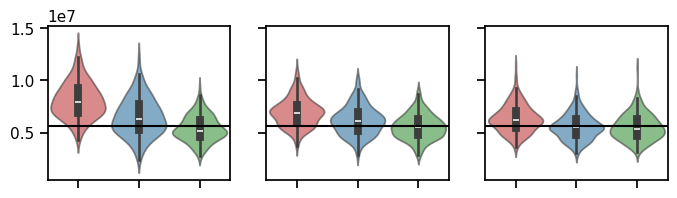

In [22]:
Ks = [5, 10, 20]
Kind = 2
# fig, ax = plt.subplots(figsize=(2.5,2))
fig, ax = plt.subplots(1,3,figsize=(8,2), sharey=True)
for Kind, K in enumerate(Ks):
    data = np.vstack([naive_list[Kind], model_list[Kind], oracle_list[Kind]]).T
    colors = ['tab:red', 'tab:blue', 'tab:green']
    sns.violinplot(data=data, width=1.0, gap=0.1, palette=colors, alpha=0.6, inner='box', ax=ax[Kind])
    ax[Kind].axhline(plot_dict['true'][0]/Ks[2], color='k')
    ax[Kind].set_xticks([0,1,2])
    ax[Kind].set_xticklabels([])
    # ax.set_ylim([10000,110000])
    plt.ticklabel_format(axis='y', style='sci', scilimits=(0, 0))
    # ax.set_ylim([0,1.5e7])

# save_name = os.path.join(save_path, f'2eigval1K_all.png')
# plt.savefig(save_name, dpi=600, bbox_inches="tight")

    # ax.set_title(f'K = {Ks[Kind]}')

(0.0, 15000000.0)

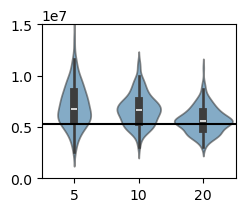

In [28]:

import seaborn as sns
fig, ax = plt.subplots(figsize=(2.5,2))
data = np.vstack(model_list).T
test = ['tab:blue', 'tab:red', 'tab:green']
sns.violinplot(data=data, width=1.0, gap=0.1, color='tab:blue', alpha=0.6, inner='box')
ax.axhline(plot_dict['true'][0]/K, color='k')
ax.set_xticks([0,1,2])
ax.set_xticklabels(['5', '10', '20'])
# ax.set_ylim([10000,110000])
plt.ticklabel_format(axis='y', style='sci', scilimits=(0, 0))
ax.set_ylim([0,1.5e7])

In [ ]:
import seaborn as sns
K_ind = 0
fig, ax = plt.subplots(figsize=(2.5,2))
data = np.vstack(naive_list).T
sns.violinplot(data=data, width=1.0, gap=0.1, color='tab:red', alpha=0.6, inner='box')
ax.axhline(plot_dict['true'][0]/K, color='k')
ax.set_xticks([0,1,2])
ax.set_xticklabels(['5', '10', '20'])
ax.set_ylim([0,1.5e7])

(0.0, 15000000.0)

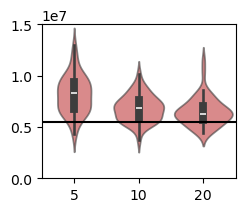

In [50]:
import seaborn as sns
fig, ax = plt.subplots(figsize=(2.5,2))
data = np.vstack(naive_list).T
sns.violinplot(data=data, width=1.0, gap=0.1, color='tab:red', alpha=0.6, inner='box')
ax.axhline(plot_dict['true'][0]/K, color='k')
ax.set_xticks([0,1,2])
ax.set_xticklabels(['5', '10', '20'])
ax.set_ylim([0,1.5e7])

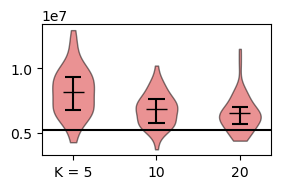

In [82]:
data = np.vstack(naive_list).T
# data = np.random.randn(50,3)
category_labels = ['K = 5', '10', '20']
# colors = ['tab:red' for x in range(3)]
fig, ax = plt.subplots(figsize=(3,2))
# plt.violinplot(data, positions=np.arange(len(category_labels)), showmeans=True)
plot_sampling_dists_violin(ax, data, category_labels, violin_colors='tab:red')
ax.axhline(plot_dict['true'][0]/K, color='k')
# ax.set_ylabel(r'$\hat{\lambda}/K$')
# ax.set_title(f'Naive')
# # ax.set_yscale('log')

Text(0.5, 1.0, 'Model')

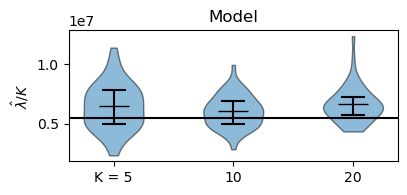

In [25]:
data = np.vstack(model_list).T
# data = np.random.randn(50,3)
category_labels = ['K = 5', '10', '20']
# colors = ['tab:red' for x in range(3)]
fig, ax = plt.subplots(figsize=(4,2))
# plt.violinplot(data, positions=np.arange(len(category_labels)), showmeans=True)
plot_sampling_dists_violin(ax, data, category_labels, violin_colors='tab:blue')
ax.axhline(plot_dict['true'][0]/K, color='k')
ax.set_ylabel(r'$\hat{\lambda}/K$')
ax.set_title(f'Model')
# ax.set_ylim([20000,100000])
# # ax.set_yscale('log')

(0.0, 15000000.0)

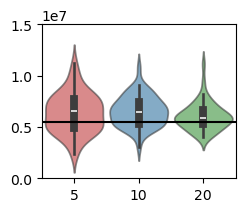

In [62]:
import seaborn as sns
fig, ax = plt.subplots(figsize=(2.5,2))
data = np.vstack(model_list).T
test = ['tab:blue', 'tab:red', 'tab:green']
sns.violinplot(data=data, width=1.0, gap=0.1, color='tab:blue', alpha=0.6, inner='box')
ax.axhline(plot_dict['true'][0]/K, color='k')
ax.set_xticks([0,1,2])
ax.set_xticklabels(['5', '10', '20'])
# ax.set_ylim([10000,110000])
plt.ticklabel_format(axis='y', style='sci', scilimits=(0, 0))
ax.set_ylim([0,1.5e7])

(0.0, 15000000.0)

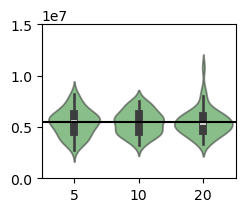

In [52]:
import seaborn as sns
fig, ax = plt.subplots(figsize=(2.5,2))
data = np.vstack(oracle_list).T
sns.violinplot(data=data, width=1.0, gap=0.1, color='tab:green', alpha=0.6, inner='box')
ax.axhline(plot_dict['true'][0]/K, color='k')
ax.set_xticks([0,1,2])
ax.set_xticklabels(['5', '10', '20'])
# ax.set_ylim([10000,110000])
plt.ticklabel_format(axis='y', style='sci', scilimits=(0, 0))
ax.set_ylim([0,1.5e7])



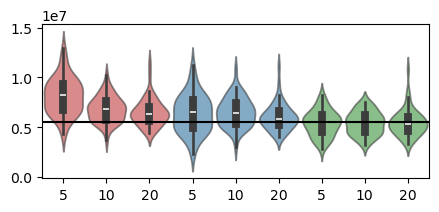

In [53]:
import seaborn as sns
fig, ax = plt.subplots(figsize=(5,2))
data0 = np.vstack(naive_list).T
data1 = np.vstack(model_list).T
data2 = np.vstack(oracle_list).T
data = jnp.hstack([data0, data1, data2])

colors = ['tab:red', 'tab:red', 'tab:red', 'tab:blue', 'tab:blue', 'tab:blue', 'tab:green', 'tab:green', 'tab:green']

sns.violinplot(data=data, width=1.0, gap=0.1, palette=colors, alpha=0.6, inner='box')
ax.axhline(plot_dict['true'][0]/K, color='k')
ax.set_xticks([0,1,2,3,4,5,6,7,8])
ax.set_xticklabels(['5', '10', '20', '5', '10', '20', '5', '10', '20'])
# ax.set_ylim([10000,110000])
plt.ticklabel_format(axis='y', style='sci', scilimits=(0, 0))


In [99]:
naive_list = []
model_list = []
oracle_list = []
for K in Ks:
    # plot_dict = get_plot_dict(eigval1_pushforward_model_true_oracle, cfg, scale_power, K, L, mu, seeds)
    plot_dict = get_plot_dict(gcoh_pushforward_model_true_oracle, cfg, scale_power, K, L, mu, seeds)
    naive_list.append(jnp.array(plot_dict['naive']))
    oracle_list.append(jnp.array(plot_dict['oracle']))
    model_list.append(jnp.array(plot_dict['model']))

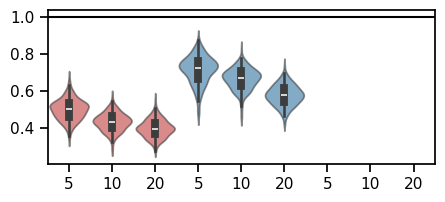

In [100]:
import seaborn as sns
fig, ax = plt.subplots(figsize=(5,2))
data0 = np.vstack(naive_list).T
data1 = np.vstack(model_list).T
data2 = np.vstack(oracle_list).T
data = jnp.hstack([data0, data1, data2])

colors = ['tab:red', 'tab:red', 'tab:red', 'tab:blue', 'tab:blue', 'tab:blue', 'tab:green', 'tab:green', 'tab:green']

sns.violinplot(data=data, width=1.0, gap=0.1, palette=colors, alpha=0.6, inner='box')
ax.axhline(plot_dict['true'][0], color='k')
ax.set_xticks([0,1,2,3,4,5,6,7,8])
ax.set_xticklabels(['5', '10', '20', '5', '10', '20', '5', '10', '20'])
# ax.set_ylim([10000,110000])
plt.ticklabel_format(axis='y', style='sci', scilimits=(0, 0))


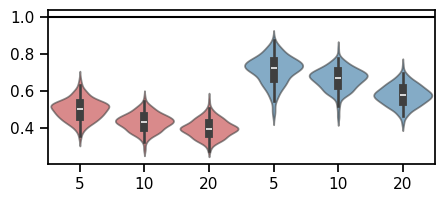

In [101]:
import seaborn as sns
fig, ax = plt.subplots(figsize=(5,2))
data0 = np.vstack(naive_list).T
data1 = np.vstack(model_list).T
data2 = np.vstack(oracle_list).T
data = jnp.hstack([data0, data1])

colors = ['tab:red', 'tab:red', 'tab:red', 'tab:blue', 'tab:blue', 'tab:blue']

sns.violinplot(data=data, width=1.0, gap=0.1, palette=colors, alpha=0.6, inner='box')
ax.axhline(plot_dict['true'][0], color='k')
ax.set_xticks([0,1,2,3,4,5])
ax.set_xticklabels(['5', '10', '20', '5', '10', '20'])
# ax.set_ylim([10000,110000])
plt.ticklabel_format(axis='y', style='sci', scilimits=(0, 0))

# save_name = os.path.join(save_path, f'2gcoh.png')
# plt.savefig(save_name, dpi=600, bbox_inches="tight")

(0.0, 1.05)

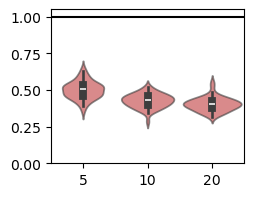

In [58]:
import seaborn as sns
fig, ax = plt.subplots(figsize=(2.5,2))
data = np.vstack(naive_list).T
sns.violinplot(data=data, width=1.0, gap=0.1, color='tab:red', alpha=0.6, inner='box')
ax.axhline(plot_dict['true'][0], color='k')
ax.set_xticks([0,1,2])
ax.set_xticklabels(['5', '10', '20'])
ax.set_ylim([0.0,1.05])

(0.0, 1.05)

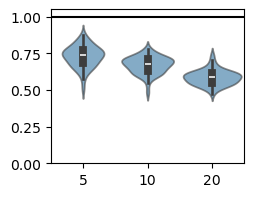

In [59]:
import seaborn as sns
fig, ax = plt.subplots(figsize=(2.5,2))
data = np.vstack(model_list).T
test = ['tab:blue', 'tab:red', 'tab:green']
sns.violinplot(data=data, width=1.0, gap=0.1, color='tab:blue', alpha=0.6, inner='box')
ax.axhline(plot_dict['true'][0], color='k')
ax.set_xticks([0,1,2])
ax.set_xticklabels(['5', '10', '20'])
# ax.set_ylim([10000,110000])
plt.ticklabel_format(axis='y', style='sci', scilimits=(0, 0))
# ax.set_ylim([0,1.5e7])
ax.set_ylim([0.0,1.05])

### hmm 
Not great - but it does look like *global* coherence should be improved... based on plot above


In [33]:
data1 = np.vstack(model_list).T
data2 = np.vstack(oracle_list).T
data = jnp.hstack([data1, data2])
data.shape

(200, 6)

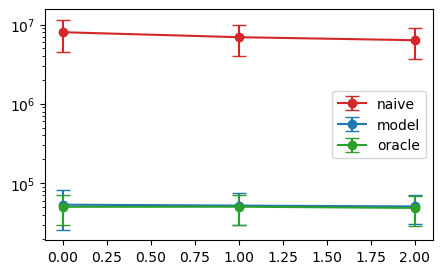

In [23]:
lists = [naive_list, model_list, oracle_list]
colors = ['tab:red', 'tab:blue', 'tab:green']
labels = ['naive', 'model', 'oracle']
fig, ax = plt.subplots(figsize=(5,3))
for i, data_list in enumerate(lists):
    data = np.vstack(data_list).T
    mean = data.mean(0)
    std = data.std(0)
    x = np.arange(3)
    ax.errorbar(x, mean, yerr=2*std, capsize=5, marker='o', color=colors[i], label=labels[i])
plt.legend()
plt.yscale('log')

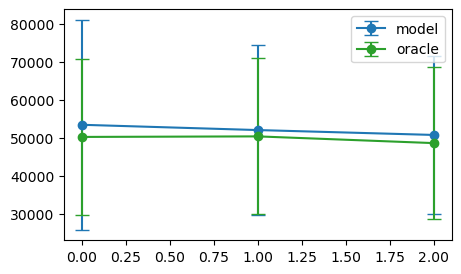

In [24]:
lists = [model_list, oracle_list]
colors = ['tab:blue', 'tab:green']
labels = ['model', 'oracle']
fig, ax = plt.subplots(figsize=(5,3))
for i, data_list in enumerate(lists):
    data = np.vstack(data_list).T
    mean = data.mean(0)
    std = data.std(0)
    x = np.arange(3)
    ax.errorbar(x, mean, yerr=2*std, capsize=5, marker='o', color=colors[i], label=labels[i])
plt.legend()
# plt.yscale('log')

In [35]:
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
import numpy as np

def plot_complex_std_contours(means, std_reals, std_imags, ax=None, n_std=1.0, colors=None, alpha=0.3):
    """
    Plot ellipses representing the standard deviations of complex-valued scalar random variables.
    
    Parameters:
        means: array-like of complex
            Complex means (centers of ellipses)
        std_reals: array-like of float
            Standard deviations of real parts
        std_imags: array-like of float
            Standard deviations of imaginary parts
        ax: matplotlib Axes, optional
            Axis to plot on. If None, a new figure and axis are created.
        n_std: float
            Number of standard deviations to scale the ellipse (default 1.0)
        colors: list of str, optional
            Colors for each ellipse. If None, default matplotlib colors are used.
        alpha: float
            Transparency of the ellipses
    """
    if ax is None:
        fig, ax = plt.subplots(figsize=(6, 6))

    if colors is None:
        colors = plt.cm.tab10(np.arange(len(means)) % 10)

    for i, (mu, std_r, std_i) in enumerate(zip(means, std_reals, std_imags)):
        ellipse = Ellipse(
            xy=(mu.real, mu.imag),
            width=2 * n_std * std_r,
            height=2 * n_std * std_i,
            edgecolor=colors[i],
            facecolor=colors[i],
            alpha=alpha,
            label=f'RV {i+1}'
        )
        ax.add_patch(ellipse)
        ax.plot(mu.real, mu.imag, 'o', color=colors[i])  # mean point


In [33]:
def plot_complex_bounds_contours(means, real_lows, real_highs, imag_lows, imag_highs, ax=None, colors=None, alpha=0.3):
    """
    Plot ellipses representing the specified real and imaginary bounds for complex-valued scalar RVs.

    Parameters:
        real_lows, real_highs: array-like of floats
            Lower and upper bounds for the real parts
        imag_lows, imag_highs: array-like of floats
            Lower and upper bounds for the imaginary parts
        ax: matplotlib Axes, optional
            Axis to plot on. If None, a new figure and axis are created.
        colors: list of str, optional
            Colors for each ellipse. If None, default matplotlib colors are used.
        alpha: float
            Transparency of the ellipses
    """
    if ax is None:
        fig, ax = plt.subplots(figsize=(6, 6))

    N = len(real_lows)
    if colors is None:
        colors = plt.cm.tab10(np.arange(N) % 10)

    labels = ['naive', 'model', 'oracle']
    markers = ['s', 'o', '^']
    for i in range(N):
        # Compute ellipse center and width/height
        center_real = (real_lows[i] + real_highs[i]) / 2
        center_imag = (imag_lows[i] + imag_highs[i]) / 2
        width = real_highs[i] - real_lows[i]
        height = imag_highs[i] - imag_lows[i]

        if i == 1:
            istyle = 'dotted'
            fcolor = 'none'
            alpha = 1
            ecolor = colors[i]
        else:
            istyle = 'none'
            fcolor = colors[i]
            alpha = 0.3
            ecolor = colors[i]

        # if i == 0:
        #     ecolor = 'none'
        # else:
        #     ecolor = colors[i]

        ellipse = Ellipse(
            xy=(center_real, center_imag),
            width=width,
            height=height,
            # edgecolor=colors[i],
            edgecolor=ecolor,
            facecolor=fcolor,
            alpha=alpha,
            linestyle=istyle,
            linewidth=2
        )
        ax.add_patch(ellipse)
        # ax.plot(center_real, center_imag, 'o', color=colors[i])  # center point
        ax.plot(means.real, means.imag, marker=markers[i], markersize=5, color=colors[i], label=labels[i], linestyle=None)  # mean point

In [82]:
from cohlib.plot import get_eigvec
from cohlib.utils import rotate_eigvecs
def eigvec1(cfg, seed, eigrank=1, gseed=0, jind_nz=0):
    cfg.latent.gamma_seed = gseed
    cfg.latent.seed = seed
    cfg.obs.seed = seed
    nz_model = jnp.array([cfg.latent.target_freq_ind])

    temp_params = {'lcfg': cfg.latent, 'ocfg': cfg.obs, 
            'nz_model': nz_model, 'K': cfg.latent.K}
    model_dir = conf.get_model_dir(cfg, temp_params)

    res = pickle_open(os.path.join(model_dir, 'res.pkl'))

    lrccn_true = conf.create_lrccn_basic_rank1(cfg.latent)
    eigvec_true = lrccn_true.eigvecs[0,:,eigrank-1]

    # eigvec_model = rotate_eigvecs(get_ccn_fullrank_eigvecs(res['ccn_est']))[0,:,eigrank-1]
    eigvec_model = get_ccn_fullrank_eigvecs(res['ccn_est'])[0,:,eigrank-1]

    latent_dir = conf.get_latent_dir(cfg.latent)
    latent_load = pickle_open(os.path.join(latent_dir, 'latent_sim.pkl'))
    zs_nz = latent_load['zs_nz']
    nz_true = latent_load['nz']

    gamma_oracle = jnp.einsum('jkl,jil->jkil', zs_nz, zs_nz.conj()).mean(-1)
    eigvec_oracle = get_eigvec(gamma_oracle[jind_nz,:,:], eigrank)
    # eigvec_oracle = eigvec_oracle*jnp.exp(-1j*jnp.angle(eigvec_oracle[0]))

    obs_dir = conf.get_obs_dir(cfg.obs, latent_dir)
    obs_load = pickle_open(os.path.join(obs_dir, 'obs_sim.pkl'))
    obs = obs_load['obs']

    if cfg.model.inherit_lcfg is True:
        nz_model = nz_true
    else:
        raise NotImplementedError

    obs_type = cfg.obs.obs_type
    if obs_type == 'gaussian':
        naive_est = naive_estimator(obs, nz_model)
    elif obs_type in ['pp_relu', 'pp_log']:
        naive_est = naive_estimator(obs, nz_model)*1e6
    else:
        raise ValueError
    eigvec_naive = get_eigvec(naive_est[jind_nz,:,:], eigrank)
    # eigvec_naive = eigvec_naive*jnp.exp(-1j*jnp.angle(eigvec_naive[0]))

    return eigvec_true, eigvec_oracle, eigvec_model, eigvec_naive

# L = 5; mu = 0.8; K = 3
# get and store naive; oracle; true; model values


In [29]:
def eigvec1_pushforward_model_true_oracle(cfg, seed, eigrank=1, gseed=0, jind_nz=0):
    cfg.latent.gamma_seed = gseed
    cfg.latent.seed = seed
    cfg.obs.seed = seed
    nz_model = jnp.array([cfg.latent.target_freq_ind])

    K = cfg.latent.K
    mu = cfg.obs.mu
    mus = jnp.repeat(mu, K)

    latent_dir = conf.get_latent_dir(cfg.latent)
    latent_load = pickle_open(os.path.join(latent_dir, 'latent_sim.pkl'))

    obs_dir = conf.get_obs_dir(cfg.obs, latent_dir)
    obs_load = pickle_open(os.path.join(obs_dir, 'obs_sim.pkl'))


    freqs = latent_load['freqs']

    temp_params = {'lcfg': cfg.latent, 'ocfg': cfg.obs, 
            'nz_model': nz_model, 'K': cfg.latent.K}
    model_dir = conf.get_model_dir(cfg, temp_params)

    res = pickle_open(os.path.join(model_dir, 'res.pkl'))

    lrccn_true = conf.create_lrccn_basic_rank1(cfg.latent)
    # eigvec_true = lrccn_true.eigvecs[0,:,eigrank-1]
    gamma_true_pushforward_mc = get_pushforward_lrccn_mc(lrccn_true, nz_model)
    eigvecs_true = jnp.linalg.eigh(gamma_true_pushforward_mc.squeeze())[1][:,::-1]
    eigvec_true = rotate_eigvecs(eigvecs_true[None,:,:])[0,:,eigrank-1]

    # eigvec_model = rotate_eigvecs(get_ccn_fullrank_eigvecs(res['ccn_est']))[0,:,eigrank-1]
    gamma_model_pushforward_mc = get_pushforward_model_est_mc(res, mus, nz_model, freqs)
    # gamma_model_pushforward_mc = get_pushforward_lrccn_mc(lrccn_true, nz_model)
    eigvecs_model = jnp.linalg.eigh(gamma_model_pushforward_mc.squeeze())[1][:,::-1]
    eigvec_model = rotate_eigvecs(eigvecs_model[None,:,:])[0,:,eigrank-1]

    zs_nz = latent_load['zs_nz']
    nz_true = latent_load['nz']

    # gamma_oracle = jnp.einsum('jkl,jil->jkil', zs_nz, zs_nz.conj()).mean(-1)
    gamma_oracle = jnp.einsum('jkl,jil->jkil', zs_nz, zs_nz.conj()).mean(-1)
    gamma_oracle_eigvals = jnp.linalg.eigh(gamma_oracle.squeeze())[0][::-1] 
    gamma_oracle_eigvecs = jnp.linalg.eigh(gamma_oracle.squeeze())[1][:,::-1] 
    num_psd_eigvals = (jnp.linalg.eigh(gamma_oracle.squeeze())[0][::-1] >= 0).sum()
    # num_psd_eigvals = 1
    print(num_psd_eigvals)

    lrccn_oracle = conf.create_lrccn_basic_rank1(cfg.latent)
    lrccn_oracle.eigvals = gamma_oracle_eigvals[None,:num_psd_eigvals]
    lrccn_oracle.eigvecs = gamma_oracle_eigvecs[None,:,:num_psd_eigvals]
    gamma_oracle_pushforward_mc = get_pushforward_lrccn_mc(lrccn_oracle, nz_model)
    # eigvecs_oracle = jnp.linalg.eigh(gamma_oracle_pushforward_mc)[1][:,::-1]
    # eigvec_oracle = rotate_eigvecs(eigvecs_oracle[None,:,:])[0,:,eigrank-1].squeeze()

    eigvec_oracle = get_eigvec(gamma_oracle_pushforward_mc.squeeze(), eigrank)
    eigvec_oracle = eigvec_oracle*jnp.exp(-1j*jnp.angle(eigvec_oracle[0]))

    obs = obs_load['obs']

    if cfg.model.inherit_lcfg is True:
        nz_model = nz_true
    else:
        raise NotImplementedError

    obs_type = cfg.obs.obs_type
    if obs_type == 'gaussian':
        naive_est = naive_estimator(obs, nz_model)
    elif obs_type in ['pp_relu', 'pp_log']:
        naive_est = naive_estimator(obs, nz_model)*1e6
    else:
        raise ValueError
    eigvecs_naive = jnp.linalg.eigh(naive_est)[1][:,::-1]
    # eigvec_naive = rotate_eigvecs(eigvecs_naive[None,:,:])[0,:,eigrank-1].squeeze()
    eigvec_naive = get_eigvec(naive_est[jind_nz,:,:], eigrank)
    eigvec_naive = eigvec_naive*jnp.exp(-1j*jnp.angle(eigvec_naive[0]))

    return eigvec_true, eigvec_oracle, eigvec_model, eigvec_naive

# L = 5; mu = 0.8; K = 3
# get and store naive; oracle; true; model values


In [30]:
num_seeds = 200
seed_mod = 0
seeds = [x + seed_mod for x in range(num_seeds)]
dim = 2
datas = []
trues = []
Ks = [5, 10, 20]
for i, K in enumerate(Ks):
    plot_dict = get_plot_dict(eigvec1_pushforward_model_true_oracle, cfg, scale_power, K, L, mu, seeds)
    data_raw = jnp.stack([jnp.array(plot_dict['naive']), jnp.array(plot_dict['model']), jnp.array(plot_dict['oracle'])]).swapaxes(0,1)# / K
    # data_raw = jnp.stack([jnp.array(plot_dict['naive']), jnp.array(plot_dict['model'])]).swapaxes(0,1)# / K
    # data_raw = jnp.stack([jnp.array(plot_dict['naive'])]).swapaxes(0,1)# / K
    datas.append(data_raw)

    true = plot_dict['true'][0]
    trues.append(true)

3
3
4
2
4
3
3
2
3
3
4
2
3
4
3
3
3
3
3
4
2
4
3
3
3
2
4
3
2
3
3
4
2
4
3
4
3
3
3
3
3
3
3
3
3
3
3
3
3
3
4
4
2
2
2
3
4
3
3
3
3
3
2
3
3
4
3
3
2
3
2
3
4
3
3
3
3
3
3
3
3
3
3
4
4
4
4
3
4
2
4
4
3
3
4
3
3
3
3
2
3
3
3
3
2
4
3
3
3
3
3
3
3
4
2
3
2
3
2
3
3
3
3
3
3
3
3
3
3
3
3
3
4
2
3
3
3
4
3
3
3
4
3
3
3
3
3
3
2
2
2
3
2
2
4
3
3
4
3
4
4
2
4
3
3
3
3
3
3
3
2
3
2
2
2
3
3
4
3
3
2
4
3
3
3
2
3
3
2
3
2
3
3
3
3
3
3
4
4
2
5
5
5
6
6
5
6
6
5
5
4
7
6
5
4
5
6
5
6
5
5
6
6
6
6
5
6
6
6
5
5
5
5
7
5
6
5
6
5
4
6
5
5
6
6
5
6
5
6
5
6
6
5
5
5
4
5
6
6
5
6
4
5
6
6
6
5
5
6
5
5
5
6
6
5
5
5
6
5
5
6
5
5
5
5
6
5
5
6
6
6
6
5
5
5
5
6
5
6
6
6
5
5
4
5
5
5
6
5
5
5
6
6
5
6
7
5
5
5
6
5
5
5
5
6
7
5
6
5
6
6
6
7
5
7
5
5
5
5
5
6
6
6
7
4
5
4
6
5
5
5
5
4
6
5
7
5
5
5
6
5
5
5
6
4
7
4
6
6
5
6
6
5
5
6
5
6
6
6
6
5
5
5
6
6
5
5
5
5
5
5
6
5
6
4
7
6
5
6
7
10
11
10
9
9
9
11
10
11
10
11
10
10
12
11
10
10
11
11
10
10
9
10
10
12
11
10
10
10
9
9
11
11
10
12
11
11
11
10
12
11
9
10
11
12
10
11
10
10
11
11
12
11
11
11
11
12
11
12
11
11
10
11
11
9
9
9
9
10
11
1

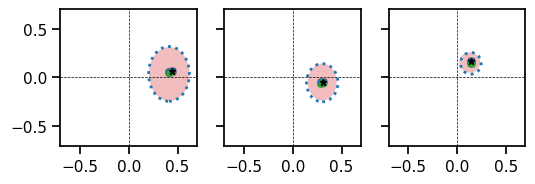

In [37]:
dim = 4
fig, ax = plt.subplots(1,3,figsize=(6,3), sharey=True)
for i, K in enumerate(Ks):
    data = datas[i][:,:,dim]
    true = trues[i][dim]
    # plot_dict = get_plot_dict(eigvec1, cfg, scale_power, K, L, mu, seeds)
    # data_raw = jnp.stack([jnp.array(plot_dict['naive']), jnp.array(plot_dict['model']), jnp.array(plot_dict['oracle'])]).swapaxes(0,1)# / K
    # data = data_raw[:,:,dim]

    means = data.mean(0)
    reals_low = data.real.sort(0)[5,:]
    reals_high = data.real.sort(0)[195,:]
    imags_low = data.imag.sort(0)[5,:]
    imags_high = data.imag.sort(0)[195,:]
    # colors = ['tab:red', 'tab:blue']
    colors = ['tab:red', 'tab:blue', 'tab:green']
    plot_complex_bounds_contours(means, reals_low, reals_high, imags_low, imags_high, ax=ax[i], colors=colors, alpha=0.3)
    ax[i].plot(true.real, true.imag, color='k', marker='*', markersize=5, label='true', linestyle=None)
    ax[i].axhline(0, color='k', linestyle='--', linewidth=0.5)
    ax[i].axvline(0, color='k', linestyle='--', linewidth=0.5)
    ax[i].set_xlim([-0.7, 0.7])
    ax[i].set_ylim([-0.7, 0.7])
    # ax.set_xlabel('Real')
    # if i == 0:
    #     ax.set_ylabel('Imag')
    #     # ax.legend()
    ax[i].set_aspect('equal')
    # ax[i].legend()
    # ax.set_title(f'K = {K}')
    # plt.grid(True)
    
save_name = os.path.join(save_path, f'2eigvec1.png')
plt.savefig(save_name, dpi=600, bbox_inches="tight")

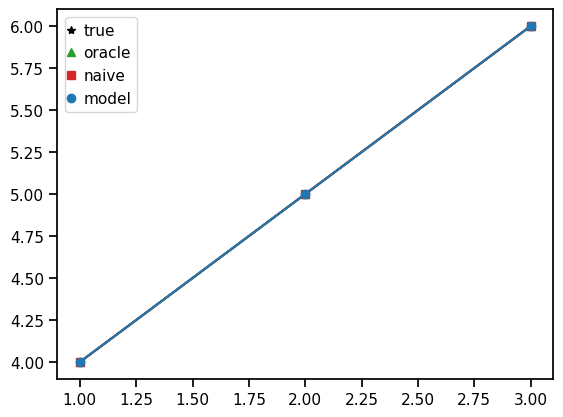

In [92]:
plt.rcParams['legend.handlelength'] = 0

plt.plot([1, 2, 3], [4, 5, 6], color='k', marker='*', label='true')
plt.plot([1, 2, 3], [4, 5, 6], color='tab:green', marker='^', label='oracle')
plt.plot([1, 2, 3], [4, 5, 6], color='tab:red', marker='s', label='naive')
plt.plot([1, 2, 3], [4, 5, 6], color='tab:blue', marker='o', label='model')
plt.legend()
save_name = os.path.join(save_path, f'2dummy_evec.png')
plt.savefig(save_name, dpi=600, bbox_inches="tight")

In [ ]:
plot_dict['oracle'][7]

Array([ 0.23980662+1.11813954e-08j, -0.06739088+8.62308666e-02j,
       -0.32782498-1.26240566e-01j,  0.02487379+1.60341889e-01j,
        0.12851267-2.80573040e-01j, -0.01135241-1.12817004e-01j,
       -0.01798275-1.61815137e-01j, -0.12549733+4.57052514e-02j,
       -0.01300833-1.47480220e-01j,  0.09501674+1.96560875e-01j,
       -0.17541488+1.20008156e-01j, -0.11965483+2.37390354e-01j,
       -0.18386821+2.59758551e-02j, -0.02499505+1.53100267e-01j,
        0.10138527+1.97601199e-01j, -0.14380667-3.47379714e-01j,
        0.06375863-2.72196442e-01j,  0.24999751-3.90646756e-02j,
       -0.03827564-6.56931056e-03j,  0.21313328-6.76328912e-02j],      dtype=complex64)

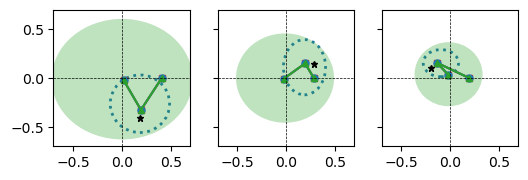

In [ ]:
fig, ax = plt.subplots(1,3,figsize=(6,3), sharey=True)
for i, K in enumerate(Ks):
    data = datas[i]
    true = trues[i]
    # plot_dict = get_plot_dict(eigvec1, cfg, scale_power, K, L, mu, seeds)
    # data_raw = jnp.stack([jnp.array(plot_dict['naive']), jnp.array(plot_dict['model']), jnp.array(plot_dict['oracle'])]).swapaxes(0,1)# / K
    # data = data_raw[:,:,dim]

    means = data.mean(0)
    reals_low = data.real.sort(0)[5,:]
    reals_high = data.real.sort(0)[195,:]
    imags_low = data.imag.sort(0)[5,:]
    imags_high = data.imag.sort(0)[195,:]
    colors = ['tab:red', 'tab:blue', 'tab:green']
    plot_complex_bounds_contours(means, reals_low, reals_high, imags_low, imags_high, ax=ax[i], colors=colors, alpha=0.3)
    ax[i].plot(true.real, true.imag, color='k', marker='*', markersize=5)
    ax[i].axhline(0, color='k', linestyle='--', linewidth=0.5)
    ax[i].axvline(0, color='k', linestyle='--', linewidth=0.5)
    ax[i].set_xlim([-0.7, 0.7])
    ax[i].set_ylim([-0.7, 0.7])
    # ax[i].set_xlabel('Real')
    # if i == 0:
    #     ax[i].set_ylabel('Imag')
    #     # ax[i].legend()
    ax[i].set_aspect('equal')
    # ax[i].set_title(f'K = {K}')
    # plt.grid(True)

Array([0.14693469+0.15676099j, 0.14668053+0.15758133j,
       0.14482802+0.17036676j], dtype=complex64)

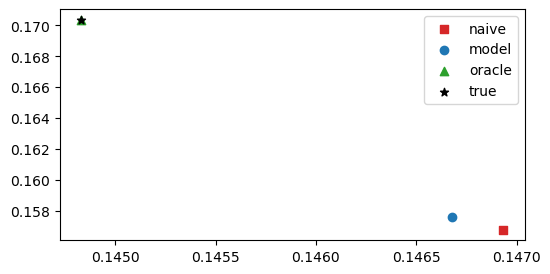

In [ ]:
markers = ['s', 'o', '^']
labels = ['naive', 'model', 'oracle']
colors = ['tab:red', 'tab:blue', 'tab:green']
fig, ax = plt.subplots(figsize=(6,3))

for i in range(3):
    ax.scatter(means[i].real, means[i].imag, marker=markers[i], color=colors[i], label=labels[i])  # mean point
ax.scatter(true.real, true.imag, color='k', marker='*', label='true')
ax.legend()

In [ ]:
a

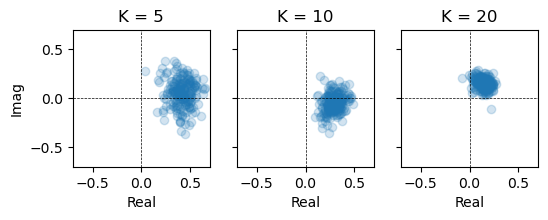

In [ ]:
fig, ax = plt.subplots(1,3,figsize=(6,3), sharey=True)
for i, K in enumerate(Ks):
    plot_dict = get_plot_dict(eigvec1, cfg, scale_power, K, L, mu, seeds)
    data_raw = jnp.stack([jnp.array(plot_dict['naive']), jnp.array(plot_dict['model']), jnp.array(plot_dict['oracle'])]).swapaxes(0,1)# / K
    data = data_raw[:,:,dim]

    # means = data.mean(0)
    # reals_low = data.real.sort(0)[2,:]
    # reals_high = data.real.sort(0)[125,:]
    # imags_low = data.imag.sort(0)[2,:]
    # imags_high = data.imag.sort(0)[125,:]
    # stds_real = data.real.std(0)*0
    # stds_imag = data.imag.std(0)*0
    # colors = ['tab:red', 'tab:blue', 'tab:green']
    # plot_complex_bounds_contours(means, reals_low, reals_high, imags_low, imags_high, ax=ax[i], colors=colors)
    ax[i].scatter(data[:,0].real, data[:,0].imag, alpha=0.2)
    # ax[i].scatter(data[:,1].real, data[:,1].imag, alpha=0.5)
    # ax[i].scatter(data[:,2].real, data[:,2].imag, alpha=0.5)
    ax[i].axhline(0, color='k', linestyle='--', linewidth=0.5)
    ax[i].axvline(0, color='k', linestyle='--', linewidth=0.5)
    ax[i].set_xlim([-0.7, 0.7])
    ax[i].set_ylim([-0.7, 0.7])
    ax[i].set_xlabel('Real')
    if i == 0:
        ax[i].set_ylabel('Imag')
        # ax[i].legend()
    ax[i].set_aspect('equal')
    ax[i].set_title(f'K = {K}')
    # plt.grid(True)

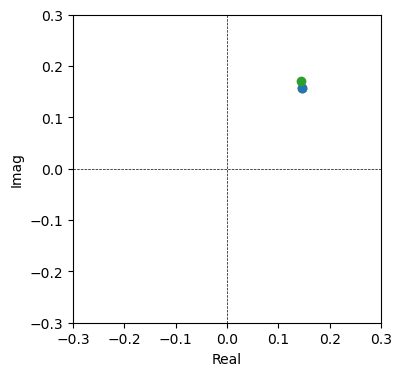

In [ ]:
fig, ax = plt.subplots(figsize=(4,4))
colors = ['tab:red', 'tab:blue', 'tab:green']
plot_complex_std_contours(means, stds_real, stds_imag, ax=ax, colors=colors)
ax.axhline(0, color='k', linestyle='--', linewidth=0.5)
ax.axvline(0, color='k', linestyle='--', linewidth=0.5)
ax.set_xlim([-0.3, 0.3])
ax.set_ylim([-0.3, 0.3])
ax.set_xlabel('Real')
ax.set_ylabel('Imag')
ax.set_aspect('equal')
# ax.legend()
# ax.set_title(f'Complex Scalar RVs with {n_std}σ Contours')
# plt.grid(True)

5
5
5
6
6
5
6
6
5
5
4
7
6
5
4
5
6
5
6
5
5
6
6
6
6
5
6
6
6
5
5
5
5
7
5
6
5
6
5
4
6
5
5
6
6
5
6
5
6
5
6
6
5
5
5
4
5
6
6
5
6
4
5
6
6
6
5
5
6
5
5
5
6
6
5
5
5
6
5
5
6
5
5
5
5
6
5
5
6
6
6
6
5
5
5
5
6
5
6
6
6
5
5
4
5
5
5
6
5
5
5
6
6
5
6
7
5
5
5
6
5
5
5
5
6
7
5
6
5
6
6
6
7
5
7
5
5
5
5
5
6
6
6
7
4
5
4
6
5
5
5
5
4
6
5
7
5
5
5
6
5
5
5
6
4
7
4
6
6
5
6
6
5
5
6
5
6
6
6
6
5
5
5
6
6
5
5
5
5
5
5
6
5
6
4
7
6
5
6
7


Text(0.5, 1.0, 'K = 10')

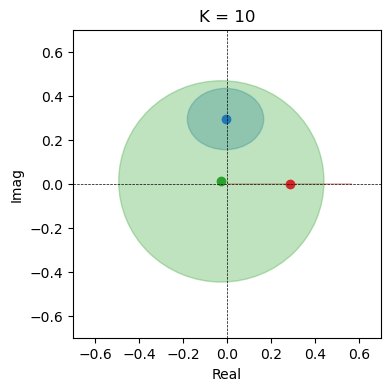

In [41]:
fig, ax = plt.subplots(1,1,figsize=(8,4), sharey=True)
i = 0
dim = 1
K = 10
plot_dict = get_plot_dict(eigvec1_pushforward_model_true_oracle, cfg, scale_power, K, L, mu, seeds)
data_raw = jnp.stack([jnp.array(plot_dict['naive']), jnp.array(plot_dict['model']), jnp.array(plot_dict['oracle'])]).swapaxes(0,1)# / K
data = data_raw[:,:,dim]

means = data.mean(0)
stds_real = data.real.std(0)
stds_imag = data.imag.std(0)
colors = ['tab:red', 'tab:blue', 'tab:green']
plot_complex_std_contours(means, stds_real, stds_imag, ax=ax, colors=colors, n_std=2.0)
ax.axhline(0, color='k', linestyle='--', linewidth=0.5)
ax.axvline(0, color='k', linestyle='--', linewidth=0.5)
ax.set_xlim([-0.7, 0.7])
ax.set_ylim([-0.7, 0.7])
ax.set_xlabel('Real')
if i == 0:
    ax.set_ylabel('Imag')
ax.set_aspect('equal')
# ax.legend()
ax.set_title(f'K = {K}')
# plt.grid(True)

3
3
4
2
4
3
3
2
3
3
4
2
3
4
3
3
3
3
3
4
2
4
3
3
3
2
4
3
2
3
3
4
2
4
3
4
3
3
3
3
3
3
3
3
3
3
3
3
3
3
4
4
2
2
2
3
4
3
3
3
3
3
2
3
3
4
3
3
2
3
2
3
4
3
3
3
3
3
3
3
3
3
3
4
4
4
4
3
4
2
4
4
3
3
4
3
3
3
3
2
3
3
3
3
2
4
3
3
3
3
3
3
3
4
2
3
2
3
2
3
3
3
3
3
3
3
3
3
3
3
3
3
4
2
3
3
3
4
3
3
3
4
3
3
3
3
3
3
2
2
2
3
2
2
4
3
3
4
3
4
4
2
4
3
3
3
3
3
3
3
2
3
2
2
2
3
3
4
3
3
2
4
3
3
3
2
3
3
2
3
2
3
3
3
3
3
3
4
4
2
5
5
5
6
6
5
6
6
5
5
4
7
6
5
4
5
6
5
6
5
5
6
6
6
6
5
6
6
6
5
5
5
5
7
5
6
5
6
5
4
6
5
5
6
6
5
6
5
6
5
6
6
5
5
5
4
5
6
6
5
6
4
5
6
6
6
5
5
6
5
5
5
6
6
5
5
5
6
5
5
6
5
5
5
5
6
5
5
6
6
6
6
5
5
5
5
6
5
6
6
6
5
5
4
5
5
5
6
5
5
5
6
6
5
6
7
5
5
5
6
5
5
5
5
6
7
5
6
5
6
6
6
7
5
7
5
5
5
5
5
6
6
6
7
4
5
4
6
5
5
5
5
4
6
5
7
5
5
5
6
5
5
5
6
4
7
4
6
6
5
6
6
5
5
6
5
6
6
6
6
5
5
5
6
6
5
5
5
5
5
5
6
5
6
4
7
6
5
6
7
10
11
10
9
9
9
11
10
11
10
11
10
10
12
11
10
10
11
11
10
10
9
10
10
12
11
10
10
10
9
9
11
11
10
12
11
11
11
10
12
11
9
10
11
12
10
11
10
10
11
11
12
11
11
11
11
12
11
12
11
11
10
11
11
9
9
9
9
10
11
1

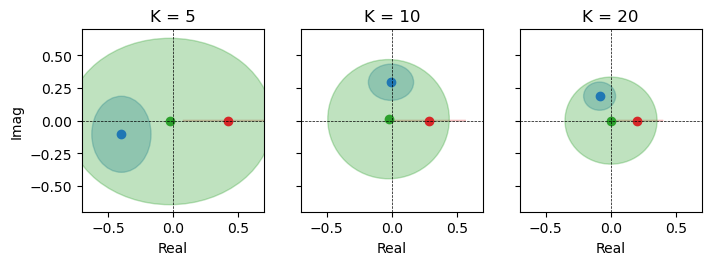

In [37]:
dim = 1
# naive_list = []
# model_list = []
# oracle_list = []

fig, ax = plt.subplots(1,3,figsize=(8,4), sharey=True)
for i, K in enumerate(Ks):
    plot_dict = get_plot_dict(eigvec1_pushforward_model_true_oracle, cfg, scale_power, K, L, mu, seeds)
    data_raw = jnp.stack([jnp.array(plot_dict['naive']), jnp.array(plot_dict['model']), jnp.array(plot_dict['oracle'])]).swapaxes(0,1)# / K
    data = data_raw[:,:,dim]

    means = data.mean(0)
    stds_real = data.real.std(0)
    stds_imag = data.imag.std(0)
    colors = ['tab:red', 'tab:blue', 'tab:green']
    plot_complex_std_contours(means, stds_real, stds_imag, ax=ax[i], colors=colors, n_std=2.0)
    ax[i].axhline(0, color='k', linestyle='--', linewidth=0.5)
    ax[i].axvline(0, color='k', linestyle='--', linewidth=0.5)
    ax[i].set_xlim([-0.7, 0.7])
    ax[i].set_ylim([-0.7, 0.7])
    ax[i].set_xlabel('Real')
    if i == 0:
        ax[i].set_ylabel('Imag')
    ax[i].set_aspect('equal')
    # ax.legend()
    ax[i].set_title(f'K = {K}')
    # plt.grid(True)

In [38]:
plot_dict['true'][4]

Array([ 0.22360685+0.00000000e+00j, -0.08495206+2.06840783e-01j,
       -0.19720563+1.05403684e-01j, -0.14986049-1.65957317e-01j,
        0.14482804+1.70366749e-01j,  0.10028265+1.99858382e-01j,
       -0.14481206+1.70380324e-01j, -0.22133729-3.17770764e-02j,
        0.03709257-2.20508829e-01j,  0.17471305+1.39554054e-01j,
       -0.06622404+2.13575229e-01j,  0.20424087+9.10256356e-02j,
       -0.21325204+6.72575161e-02j, -0.21045206+7.55639002e-02j,
        0.11790339-1.89996809e-01j,  0.22360669+1.48908803e-04j,
       -0.17139557-1.43609047e-01j,  0.20394254-9.16919857e-02j,
        0.14049135+1.73960209e-01j, -0.19987452+1.00250460e-01j],      dtype=complex64)

In [39]:
eigvec_oracle = plot_dict['oracle'][15]
eigvec_oracle = eigvec_oracle*jnp.exp(-1j*jnp.angle(eigvec_oracle[0]))
eigvec_oracle

Array([ 0.05806394+0.j        , -0.06510392-0.01109334j,
        0.0764007 -0.20596527j,  0.2718826 +0.20791613j,
        0.13225994-0.11821286j,  0.12077694+0.18089314j,
        0.0267031 +0.17211714j,  0.0394935 -0.16356479j,
        0.03559057+0.22627605j, -0.15119928-0.00973227j,
        0.15957995-0.21171007j, -0.30572557+0.02299139j,
       -0.00678362-0.3074372j , -0.09290123-0.10886757j,
       -0.3345428 +0.01756928j,  0.2094614 -0.21961415j,
        0.13898839-0.16929728j,  0.15948978+0.04779826j,
       -0.00116318-0.06813736j,  0.1418075 -0.17289366j], dtype=complex64)

K=5 - num nans = 0
K=10 - num nans = 0
K=20 - num nans = 0


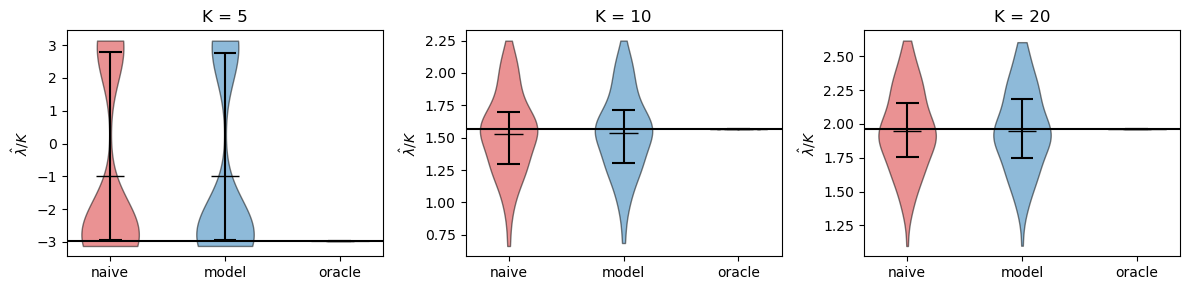

In [31]:
fig, ax = plt.subplots(1, len(Ks), figsize=(12, 3))
func = np.angle
dim = 1

for i, K in enumerate(Ks):
    plot_dict = get_plot_dict(eigvec1, cfg, scale_power, K, L, mu, seeds)
    data_raw = jnp.stack([jnp.array(plot_dict['naive']), jnp.array(plot_dict['model']), jnp.array(plot_dict['oracle'])]).swapaxes(0,1)# / K
    data = func(data_raw[:,:,dim])

    model_nans = jnp.isnan(jnp.stack(plot_dict['model'])).sum()
    print(f'K={K} - num nans = {model_nans}')
    category_labels = ['naive', 'model', 'oracle']

    plot_sampling_dists_violin(ax[i], data, category_labels, violin_colors=['tab:red', 'tab:blue', 'tab:green'])
    # plot_sampling_dists(ax[i], data, category_labels, jitter=True, jitter_strength=0.15)
    ax[i].axhline(func(plot_dict['true'][0][dim]), color='k')
    ax[i].set_ylabel(r'$\hat{\lambda}/K$')
    ax[i].set_title(f'K = {K}')
    # ax[i].set_ylim([-np.pi, np.pi])
    # ax[i].set_yscale('log')

K=5 - num nans = 0
K=10 - num nans = 0
K=20 - num nans = 0


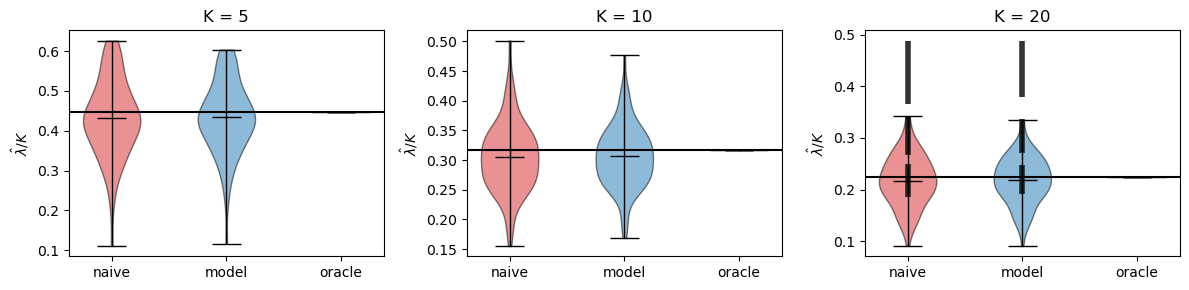

In [63]:
fig, ax = plt.subplots(1, len(Ks), figsize=(12, 3))
func = np.abs

for i, K in enumerate(Ks):
    plot_dict = get_plot_dict(eigvec1, cfg, scale_power, K, L, mu, seeds)
    data_raw = jnp.stack([jnp.array(plot_dict['naive']), jnp.array(plot_dict['model']), jnp.array(plot_dict['oracle'])]).swapaxes(0,1)# / K
    data = func(data_raw[:,:,dim])

    model_nans = jnp.isnan(jnp.stack(plot_dict['model'])).sum()
    print(f'K={K} - num nans = {model_nans}')
    category_labels = ['naive', 'model', 'oracle']

    plot_sampling_dists_violin(ax[i], data, category_labels, violin_colors=['tab:red', 'tab:blue', 'tab:green'])
    # plot_sampling_dists(ax[i], data, category_labels, jitter=True, jitter_strength=0.15)
    ax[i].axhline(func(plot_dict['true'][0][dim]), color='k')
    ax[i].set_ylabel(r'$\hat{\lambda}/K$')
    ax[i].set_title(f'K = {K}')
    # ax[i].set_ylim([-np.pi, np.pi])
    # ax[i].set_yscale('log')

In [35]:
plot_dict['true'][0][dim]

Array(-0.08495218+0.20684083j, dtype=complex64)

In [38]:
K = 5
plot_dict = get_plot_dict(eigvec1, cfg, scale_power, K, L, mu, seeds)
for dim in range(K):
    true = func(plot_dict['true'][0][dim])
    mean_naive = func(jnp.stack(plot_dict['naive'])[:,dim]).mean()
    mean_model = func(jnp.stack(plot_dict['model'])[:,dim]).mean()
    model_bias = mean_model - true
    naive_bias = mean_naive - true
    # print(f'naive bias: {naive_bias}')
    # print(f'model bias: {model_bias}')
    # print(f'bias diff (abs(naive)-abs(model)): {np.abs(naive_bias) - np.abs(model_bias)}')
    print(f'dim {dim}: {np.abs(naive_bias) - np.abs(model_bias)}')
    # print()

dim 0: 0.0035308897495269775
dim 1: 0.002431720495223999
dim 2: 0.0012249946594238281
dim 3: 5.662441253662109e-06
dim 4: 0.00043833255767822266


In [153]:
print((np.stack(naive_bias) - np.stack(model_bias)).mean())
print(np.stack(model_bias).mean())

-0.00035257562
-0.008932492


In [143]:
K = 20
plot_dict = get_plot_dict(eigvec1, cfg, K, L, mu, seeds)
naive_bias = []
model_bias = []
for dim in range(K):
    true = func(plot_dict['true'][0][dim])
    std_naive = func(jnp.stack(plot_dict['naive'])[:,dim]).std()
    std_model = func(jnp.stack(plot_dict['model'])[:,dim]).std()
    # print(f'naive std: {std_naive}')
    # print(f'model std: {std_model}')
    # print(f'std diff (naive-model): {std_naive - std_model}')
    print(f'dim {dim}: {std_naive - std_model}')
    # print()

dim 0: 0.0008225962519645691
dim 1: 0.001342136412858963
dim 2: 0.0013454332947731018
dim 3: 0.0013667084276676178
dim 4: 0.0007845722138881683
dim 5: 0.0014968663454055786
dim 6: 0.001695629209280014
dim 7: 0.0009251199662685394
dim 8: 0.0015031173825263977
dim 9: 0.0007747001945972443
dim 10: 0.0012545138597488403
dim 11: 0.0011258162558078766
dim 12: 0.0008905641734600067
dim 13: 0.00156305730342865
dim 14: 0.0007822215557098389
dim 15: 0.0012408047914505005
dim 16: 0.0007881335914134979
dim 17: 0.0014048367738723755
dim 18: 0.0009481310844421387
dim 19: 0.001450568437576294


In [124]:
L = 25
means = []
stds = []
for K in [5, 10, 20]:
    plot_dict = get_plot_dict(eigvec1, cfg, K, L, mu, seeds)
    print(f'Naive K={K}')
    mean = func(jnp.stack(plot_dict['naive'])[:,dim]).mean()
    std = func(jnp.stack(plot_dict['naive'])[:,dim]).std()
    print(f'mean: {mean}')
    print(f'std: {std}')

Naive K=5
mean: 0.4404281675815582
std: 0.11195862293243408
Naive K=10
mean: 0.3031008839607239
std: 0.08601284772157669
Naive K=20
mean: 0.2036525309085846
std: 0.05701557174324989


In [125]:
L = 25
means = []
stds = []
for K in [5, 10, 20]:
    plot_dict = get_plot_dict(eigvec1, cfg, K, L, mu, seeds)
    print(f'Model K={K}')
    mean = func(jnp.stack(plot_dict['model'])[:,dim]).mean()
    std = func(jnp.stack(plot_dict['model'])[:,dim]).std()
    print(f'mean: {mean}')
    print(f'std: {std}')

Model K=5
mean: 0.4414188861846924
std: 0.10906947404146194
Model K=10
mean: 0.30404236912727356
std: 0.0845813974738121
Model K=20
mean: 0.20440532267093658
std: 0.055648863315582275


In [ ]:
plot_dict = get_plot_dict(eigvec1, cfg, K, L, mu, seeds)
data = jnp.stack([jnp.array(plot_dict['naive']), jnp.array(plot_dict['model']), jnp.array(plot_dict['oracle'])]).swapaxes(0,1)# / K
data.shape

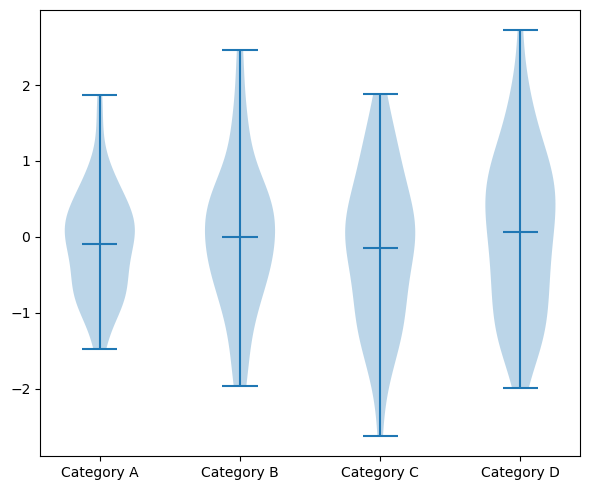

In [34]:
import matplotlib.pyplot as plt
import numpy as np

def plot_violin_category_matrix(data_matrix, category_labels):
    """
    Plot a violin plot of data points from a matrix across multiple categories.

    Parameters:
    - data_matrix: numpy array of shape (N, C), with N data points per category, C categories.
    - category_labels: List of category labels (length C).
    """

    plt.figure(figsize=(max(6, len(category_labels)), 5))
    plt.violinplot(data_matrix, positions=np.arange(len(category_labels)), showmeans=True)

    plt.xticks(np.arange(len(category_labels)), category_labels)
    plt.tight_layout()
    plt.show()

# Example Usage:
np.random.seed(42)
N, C = 50, 4
category_labels = ['Category A', 'Category B', 'Category C', 'Category D']
data_matrix = np.random.randn(N, C)
plt.violinplot(data_matrix, positions=np.arange(len(category_labels)), showmeans=True)


# Plot violin plot
plot_violin_category_matrix(data_matrix, category_labels)


In [ ]:
data = jnp.vstack([jnp.array(plot_dict['naive']), jnp.array(plot_dict['model']), jnp.array(plot_dict['oracle'])]).swapaxes(0,1) / K

In [87]:
L = 25
means = []
stds = []
for K in [5, 10, 20]:
    plot_dict = get_plot_dict(eigval1, cfg, K, L, mu, seeds)
    print(f'Oracle K={K}')
    print((jnp.stack(plot_dict['oracle'])/K).mean())
    print((jnp.stack(plot_dict['oracle'])/K).std())

Oracle K=5
10131.123
2172.7712
Oracle K=10
9972.251
1916.6827
Oracle K=20
9932.488
2137.4146


K=5 - num nans = 0
K=10 - num nans = 0
K=20 - num nans = 0


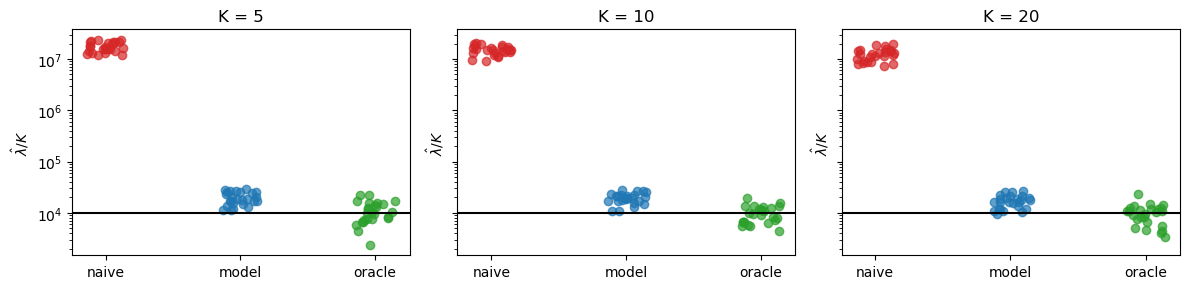

In [10]:
L = 25

Ks = [5, 10, 20]

fig, ax = plt.subplots(1, len(Ks), figsize=(12, 3), sharey=True)

for i, K in enumerate(Ks):
    plot_dict = get_plot_dict(eigval1, cfg, K, L, mu, seeds)
    data = jnp.vstack([jnp.array(plot_dict['naive']), jnp.array(plot_dict['model']), jnp.array(plot_dict['oracle'])]).swapaxes(0,1) / K
    model_nans = jnp.isnan(jnp.stack(plot_dict['model'])).sum()
    print(f'K={K} - num nans = {model_nans}')
    category_labels = ['naive', 'model', 'oracle']

    plot_sampling_dists(ax[i], data, category_labels, jitter=True, jitter_strength=0.15)
    ax[i].axhline(plot_dict['true'][0]/K, color='k')
    ax[i].set_ylabel(r'$\hat{\lambda}/K$')
    ax[i].set_title(f'K = {K}')
    ax[i].set_yscale('log')

In [84]:
K = 5
plot_dict = get_plot_dict(eigval1, cfg, K, L, mu, seeds)

In [93]:
print('Oracle')
print(jnp.stack(plot_dict['oracle']).mean())
print(jnp.stack(plot_dict['oracle']).std())
print('')
print('Naive')
print(jnp.stack(plot_dict['naive']).mean())
print(jnp.stack(plot_dict['naive']).std())
print('')
print('Model')
print(jnp.stack(plot_dict['model']).mean())
print(jnp.stack(plot_dict['model']).std())

Oracle
51509.22
11271.678

Naive
63148784.0
9690095.0

Model
62219.973
15288.3125


In [81]:
L = 25
means = []
stds = []
for K in [5, 10, 20]:
    plot_dict = get_plot_dict(eigval1, cfg, K, L, mu, seeds)
    print(f'Model K={K}')
    mean = (jnp.stack(plot_dict['model'])/K).mean()
    std = (jnp.stack(plot_dict['model'])/K).std()
    print(f'mean: {mean}')
    print(f'std: {std}')

Model K=5
mean: 12014.20703125
std: 3255.215576171875
Model K=10
mean: 11585.013671875
std: 2440.78955078125
Model K=20
mean: 11527.02734375
std: 2062.32958984375


In [83]:
L = 25
means = []
stds = []
for K in [5, 10, 20]:
    plot_dict = get_plot_dict(eigval1, cfg, K, L, mu, seeds)
    print(f'Oracle K={K}')
    mean = (jnp.stack(plot_dict['oracle'])/K).mean()
    std = (jnp.stack(plot_dict['oracle'])/K).std()
    print(f'mean: {mean}')
    print(f'std: {std}')

Oracle K=5
mean: 10131.123046875
std: 2172.771240234375
Oracle K=10
mean: 9972.2509765625
std: 1916.6827392578125
Oracle K=20
mean: 9932.48828125
std: 2137.41455078125


In [12]:
L = 5
means = []
stds = []
for K in [5, 10, 20]:
    plot_dict = get_plot_dict(eigval1, cfg, K, L, mu, seeds)
    print(f'Model K={K}')
    print((jnp.stack(plot_dict['model'])/K).mean())
    print((jnp.stack(plot_dict['model'])/K).std())

Model K=5
19644.443
5545.453
Model K=10
19656.277
4508.2715
Model K=20
17131.322
4915.058


In [97]:
means = []
stds = []
for K in [5, 10, 20]:
    plot_dict = get_plot_dict(eigval1, cfg, K, L, mu, seeds)
    print(f'Naive K={K}')
    print((jnp.stack(plot_dict['naive'])/K).mean())
    print((jnp.stack(plot_dict['naive'])/K).std()) 

Naive K=5
12629757.0
1938019.0
Naive K=10
9800701.0
1734836.0
Naive K=20
8634182.0
1079170.8


In [98]:
means = []
stds = []
for K in [5, 10, 20]:
    plot_dict = get_plot_dict(eigval1, cfg, K, L, mu, seeds)
    print(f'Oracle K={K}')
    print((jnp.stack(plot_dict['oracle'])/K).mean())
    print((jnp.stack(plot_dict['oracle'])/K).std()) 

Oracle K=5
10301.844
2254.3357
Oracle K=10
10178.751
2076.199
Oracle K=20
10301.524
1620.3984


In [11]:
def raw_xs_ns(cfg, seed, gseed=0, jind_nz=0):
    cfg.latent.gamma_seed = gseed
    cfg.latent.seed = seed
    cfg.obs.seed = seed

    latent_dir = conf.get_latent_dir(cfg.latent)
    latent_load = pickle_open(os.path.join(latent_dir, 'latent_sim.pkl'))
    zs_nz = latent_load['zs_nz']

    num_freqs = freqs.size
    zs = jnp.zeros((num_freqs, cfg.latent.K, cfg.latent.L), dtype=complex)
    zs = zs.at[nz,:,:].set(zs_nz)
    zs_0dc = jnp.apply_along_axis(add0, 0, zs)
    xs = jnp.fft.irfft(zs_0dc, axis=0)

    obs_dir = conf.get_obs_dir(cfg.obs, latent_dir)
    obs_load = pickle_open(os.path.join(obs_dir, 'obs_sim.pkl'))
    obs = obs_load['obs']

    return xs, obs

(1000, 3, 25)
(1000, 10, 25)
(1000, 25, 25)


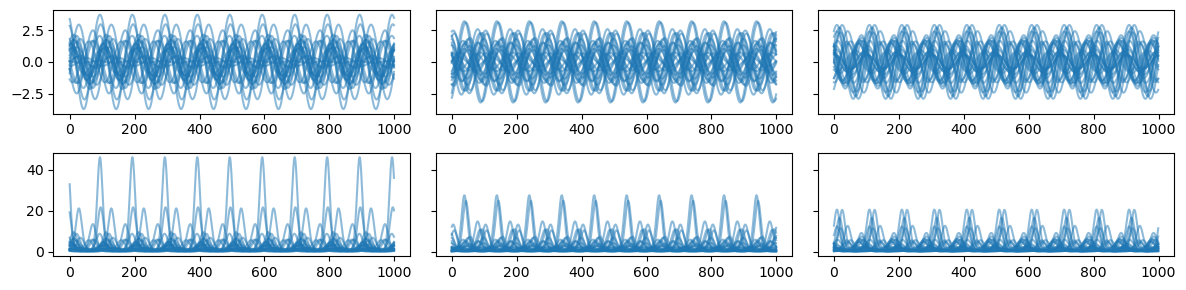

In [14]:
Ks = [3, 10, 25]
freqs = jnp.arange(500)
nz = jnp.array([cfg.latent.target_freq_ind])

fig, ax = plt.subplots(2, len(Ks), figsize=(12, 3), sharey='row')


L = 25
for i, K in enumerate(Ks):
    cfg = mod_config(cfg, K, L, mu)
    xs, obs = raw_xs_ns(cfg, 0)
    lams = jnp.exp(mu + xs)
    print(obs.shape)

    k = 0
    for l in range(L):
        ax[0,i].plot(xs[:,k,l], color='tab:blue', alpha=0.5)
    for l in range(L):
        ax[1,i].plot(lams[:,k,l], color='tab:blue', alpha=0.5)
plt.tight_layout()
    # data = jnp.vstack([jnp.array(plot_dict['naive']), jnp.array(plot_dict['oracle'])]).swapaxes(0,1) / K
    # category_labels = ['naive', 'oracle']

    # colors = ['tab:red', 'tab:green']
    # plot_sampling_dists(ax[i], data, category_labels, jitter=True, jitter_strength=0.15, colors=colors)
    # ax[i].axhline(plot_dict['true'][0]/K, color='k')
    # ax[i].set_ylabel(r'$\hat{\lambda}/K$')
    # ax[i].set_title(f'K = {K}')
    # ax[i].set_yscale('log')

In [18]:
from hydra import initialize, compose
from hydra.core.config_store import ConfigStore
def omega(cfg):
    return OmegaConf.create(cfg)
# Create Gamma with new scaling
# How is Gamma created in script?
jax_boilerplate()

Platform:  cpu
28


In [19]:
# Create config - (incorporates overrides from from command line)
Config = get_sim_config()

with initialize(version_base=None, config_path="."):
    cfg = compose(
        config_name="config", 
        # overrides=["app.name=MyNewApp", "database.port=1234"]
    )
    # print(cfg)
    
lcfg = cfg.latent
ocfg = cfg.obs

latent_dir = conf.get_latent_dir(lcfg)
obs_dir = conf.get_obs_dir(ocfg, latent_dir)

lcfg.scale_power_target = 1e5

In [20]:
lrccn = create_lrccn_basic_rank1(lcfg)
lrk_sample_seed = lcfg.seed #+ lcfg.L
lrk_sample = jr.key(lrk_sample_seed)
zs_nz = lrccn.sample_nz(lrk_sample, lcfg.L)
freqs = lrccn.freqs
nz = lrccn.nz
lcfg_resolved = OmegaConf.to_container(lcfg, resolve=True)
latent_save = {'lcfg': lcfg_resolved, 'zs_nz': zs_nz, 'nz': nz, 'freqs': freqs}
latent_savename = os.path.join(latent_dir, 'latent_sim.pkl')
pickle_save(latent_save, latent_savename) 
zs_existed = False

num_freqs = freqs.size
zs = jnp.zeros((num_freqs, lcfg.K, lcfg.L), dtype=complex)
zs = zs.at[nz,:,:].set(zs_nz)
zs_0dc = jnp.apply_along_axis(add0, 0, zs)
xs = jnp.fft.irfft(zs_0dc, axis=0)

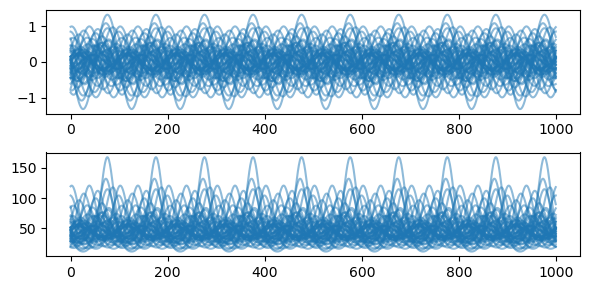

In [21]:
L = lcfg.L
k = 0
l = 0
mu = 3.8
lams = jnp.exp(mu + xs)
L_plot = L
fig, ax = plt.subplots(2,1,figsize=(6,3))
for l in range(L_plot):
    ax[0].plot(xs[:,k,l], color='tab:blue', alpha=0.5)
    ax[1].plot(lams[:,k,l], color='tab:blue', alpha=0.5)
plt.tight_layout()

In [22]:
def sample_func(scale, K, mu, seed):
    Config = get_sim_config()

    with initialize(version_base=None, config_path="."):
        cfg = compose(
            config_name="config", 
            # overrides=["app.name=MyNewApp", "database.port=1234"]
        )
        # print(cfg)
        
    lcfg = cfg.latent
    ocfg = cfg.obs
    lcfg.K = K

    lcfg.scale_power_target = scale

    lrccn = create_lrccn_basic_rank1(lcfg)
    lrk_sample_seed = seed
    lrk_sample = jr.key(lrk_sample_seed)
    zs_nz = lrccn.sample_nz(lrk_sample, lcfg.L)
    freqs = lrccn.freqs
    nz = lrccn.nz

    num_freqs = freqs.size
    zs = jnp.zeros((num_freqs, lcfg.K, lcfg.L), dtype=complex)
    zs = zs.at[nz,:,:].set(zs_nz)
    zs_0dc = jnp.apply_along_axis(add0, 0, zs)
    xs = jnp.fft.irfft(zs_0dc, axis=0)

    obs_params = ocfg
    ocfg.seed = seed
    ocfg.mu = mu
    obs = sample_obs(xs, obs_params)

    return zs_nz, xs, obs

In [23]:
def estimate_d1_func(zs_nz, obs, jind_nz=0, eigrank=1):
    gamma_oracle = jnp.einsum('jkl,jil->jkil', zs_nz, zs_nz.conj()).mean(-1)
    eigval_oracle = get_eigval(gamma_oracle[jind_nz,:,:], eigrank)
    nz_model = 9

    obs_type = cfg.obs.obs_type
    if obs_type == 'gaussian':
        naive_est = naive_estimator(obs, nz_model)
    elif obs_type in ['pp_relu', 'pp_log']:
        naive_est = naive_estimator(obs, nz_model)*1e6
    else:
        raise ValueError
    eigval_naive = get_eigval(naive_est[jind_nz,:,:], eigrank)

    return eigval_oracle, eigval_naive

In [24]:
L = 50
scale = 1e6
K = 5
mu = 2.4
seed = 0

lred = 1

zt, xt, obst = sample_func(scale, K, mu, seed)
lamt = jnp.exp(mu+xt)
print(lamt.mean())

25.77884


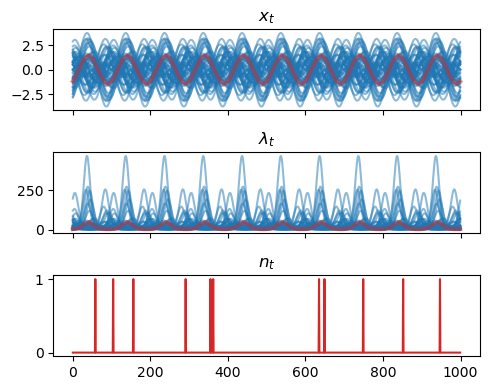

In [25]:
fig, ax = plt.subplots(3,1,figsize=(5,4), sharex=True)
for l in range(L):
    ax[0].plot(xt[:,0,l], color='tab:blue', alpha=0.5)
    ax[1].plot(lamt[:,0,l], color='tab:blue', alpha=0.5)
ax[0].plot(xt[:,0,lred], color='tab:red', alpha=0.5, linewidth=3)
ax[0].set_title(r'$x_t$')
ax[1].plot(lamt[:,0,lred], color='tab:red', alpha=0.5, linewidth=3)
ax[1].set_title(r'$\lambda_t$')
ax[2].plot(obst[:,0,lred], color='tab:red')
ax[2].set_title(r'$n_t$')
plt.tight_layout()